# Multiobjective problem

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
dist_central = np.loadtxt("CustDist_WHCentral.csv", skiprows=1, delimiter=",")[:,1:]
xy_central   = np.loadtxt("CustXY_WHCentral.csv", skiprows=1, delimiter=",")[:,1:].T

dist_corner  = np.loadtxt("CustDist_WHCorner.csv", skiprows=1, delimiter=",")[:,1:]
xy_corner    = np.loadtxt("CustXY_WHCorner.csv", skiprows=1, delimiter=",")[:,1:].T

orders       = np.loadtxt("CustOrd.csv", skiprows=1, delimiter=",")[:,1]

In [99]:
import random
from deap import tools, base, creator

def PMX(ind1, ind2):
    ind1 -= 1
    ind2 -= 1
    tools.cxPartialyMatched(ind1, ind2)
    ind1 += 1
    ind2 += 1

    return (ind1, ind2)


def inversion(ind):
    #invpoint1 = random.randint(0, len(ind) - 2)
    #invpoint2 = random.randint(invpoint1+1, len(ind)-1)
    r1 = random.randint(0, len(ind) - 1)
    r2 = random.randint(0, len(ind) - 1)
    
    invpoint1 , invpoint2 = min(r1,r2), max(r1,r2)
    
    ind[invpoint1:invpoint2+1]=list(reversed(ind[invpoint1:invpoint2+1]))

In [100]:
def evaluateMO(individual, distances, orders, max_capacity=1000):
    
    dist = distances[0, individual[0]]
    cost = max_capacity*dist
    capacity = max_capacity - orders[individual[0]]
    
    for i, f in zip(individual[:-1], individual[1:]):
        if capacity < orders[f]:
            cost += capacity*distances[i][0]
            dist += distances[i][0]
            capacity = max_capacity
            cost += capacity*distances[0][f]
            dist += distances[0][f]
            # print("Ups, go back")
        else:
            cost += capacity*distances[i][f]
            dist += distances[i][f]
        
        capacity -= orders[f]
        # print(f"Went from {i} to {f} and capacity is now {capacity} and dist is {dist}")        
    cost+=capacity*distances[0,individual[-1]]
    dist+=distances[0,individual[-1]]
    return (dist,cost/1000)

In [101]:
def init_SO_EA(ind_size, distances, orders):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
    creator.create("Individual", np.ndarray, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("indices", random.sample, range(1, ind_size+1), ind_size)
    toolbox.register("individual", tools.initIterate, creator.Individual,
                     toolbox.indices)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    toolbox.register("evaluateMO", evaluateMO, distances=distances, orders=orders)
    
    toolbox.register("mate",   PMX)
    #toolbox.register("select", tools.selRoulette) 
    toolbox.register("select", tools.selNSGA2) 
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
    toolbox.register("invert", inversion)
    
    return toolbox

In [206]:
def run_SO_EA(ind_size, distances, orders, 
              pop_size, 
              CXPB, MUTPB, INVPB,
              toolbox=None):
    
    if toolbox is None:
        toolbox = init_SO_EA(ind_size, distances, orders)
    
    population = toolbox.population(n=pop_size)
    population = toolbox.select(population, pop_size)
    
    fitnesses = list(map(toolbox.evaluateMO, population))

    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit
    # Generations     
    g = 0
    # means = []
    mins = []
    # maxs = []
    listfits=[]
    
    while g < 20_000 // pop_size:
        g += 1
        # print(f"----- Generation {g} -----")
        #population.sort(key=lambda x: x.fitness.values[0])
        offspring = tools.selTournamentDCD(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

            # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        for mutant in offspring:
            if random.random() < INVPB:
                toolbox.invert(mutant)
                del mutant.fitness.values
                
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = list(map(toolbox.evaluateMO, invalid_ind))

        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        # unique = [population[0]]
        # for n, I in enumerate((population + offspring)):
        #     if np.any((np.all(I != unique, axis=1))):
        #         unique.append(I)
        # if len(unique) > pop_size:
            # population = toolbox.select(unique, len(population))
        # else:
        population = toolbox.select(population+offspring, len(population))
            # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values for ind in population]
        listfits += [fits]
        #mean = np.mean(fits)
        #std  = np.std(fits)
        # means.append(mean)
        #mins.append(min(fits))
        # maxs.append(max(fits))
    return listfits, population

In [226]:
(listfits,population) = run_SO_EA(30, distances=dist_central, 
                                  orders=orders, 
                                  pop_size=100, 
                                  CXPB = 0.8, MUTPB = 0.2, INVPB=0.8,
                                  toolbox=None)

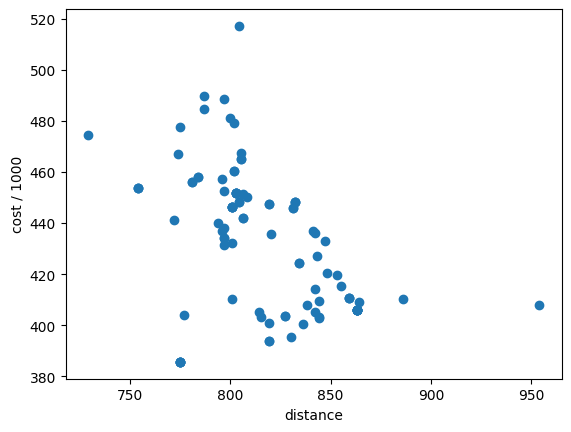

In [227]:
fits = listfits[-1]
fits_x = [x[0] for x in fits]
fits_y = [x[1] for x in fits]
plt.scatter(fits_x,fits_y)
plt.xlabel("distance")
plt.ylabel("cost / 1000")
plt.show()

In [23]:
(listfits,population) = run_SO_EA(30, distances=dist_central, 
                                  orders=orders, 
                                  pop_size=100, 
                                  CXPB = 0.8, MUTPB = 0.2, INVPB=0.4,
                                  toolbox=None)

/home/bs/.pyenv/versions/cint/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/bs/.pyenv/versions/cint/lib/python3.8/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


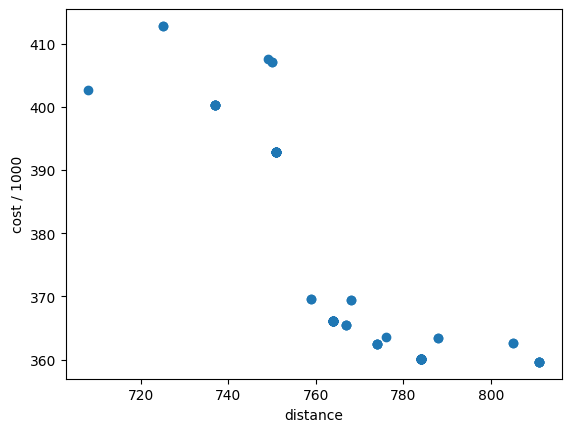

In [19]:
fits=listfits[-1]
fits_x = [x[0] for x in fits]
fits_y = [x[1] for x in fits]
plt.scatter(fits_x,fits_y)
plt.xlabel("distance")
plt.ylabel("cost / 1000")
plt.show()

In [4]:
from TSP_MO import MultipleObjectiveTSP, inversion, PMX

In [5]:
EA = MultipleObjectiveTSP(ind_size    = 50,
                        distances     = dist_central,
                        orders        = orders,
                        coords        = xy_central.T[1:11+1],
                        pop_size      = 100,
                        use_heuristic = False,
                        CXPB  = 0.8,
                        MUTPB = 0.2,
                        INVPB = 0.8)

In [10]:
result = EA.many_runs(n_runs=2)
result["best_hv"]

0.0

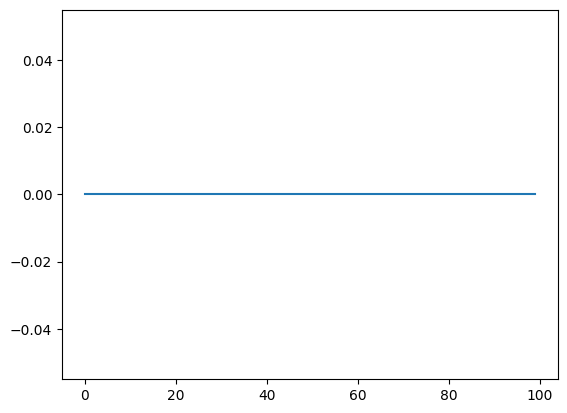

In [8]:
plt.plot(result["be"])

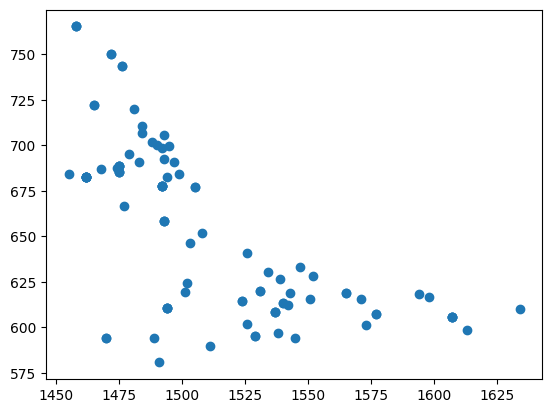

In [9]:
plt.scatter([x.fitness.values[0] for x iWARN: Device disconnectedn result["best_solution"]],[x.fitness.values[1] for x in result["best_solution"]])

In [19]:
from TSP_SO import SingleObjectiveTSP
SOEA = SingleObjectiveTSP(ind_size = 30,
                        distances= dist_central,
                        orders   = orders,
                        coords   = xy_central,
                        pop_size = 40,
                        use_heuristic = False,
                        elitist_cross = 20, 
                        elitist_size  = 3,
                        CXPB  = 0.8,
                        INVPB = 0.7)

result30WHCentralOrdFile = SOEA.many_runs(n_runs=0)

In [238]:
EA._evaluate(result30WHCentralOrdFile["best_solution"], dist_central, orders)

(518.0, 314.05)

In [14]:
EA._evaluate([10, 15, 22, 12, 25,  2, 16, 29,  1, 24, 13, 26, 28, 17,  4, 20,
         7,  5,  0, 27, 14,  3, 11,  9, 23, 18,  6,  8, 19, 21], dist_central, orders)

(568.0, 293.72)

In [15]:
globals().keys()

dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', '_i2', 'SingleObjectiveTSP', '_i3', 'np', 'plt', '_i4', 'dist_central', 'xy_central', 'dist_corner', 'xy_corner', 'orders', '_i5', '_i6', '_i7', 'SOEA', '_i8', '_i9', '_i10', 'result30WHCentralOrdFile', '_i11', '_11', '_i12', '_i13', '_i14', '_14', '_i15'])